<h1 style="color:orange;text-align:center;font-family:courier;font-size:220%">Example - Image Captioning using Transformers</h1>
<h3 style="color:orange;text-align:center;font-family:courier;font-size:110%"><u>Train a caption model from scratch on flickr30k dataset</u></h3>
<p style="text-align:center"><img src="assets/download.png" alt="ps" height="280" width="640"/>
<h3 style="color:GREEN;text-align:center;font-family:courier;font-size:90%">TRAIN - TEST - REST</h3>

#### Overview:
Image captioning models are pretty straightforward for anyone who is aware about sequence to sequence models, There are plethora of examples explaining this whole concept. This notebook can be one among them and this will ensure you a whole lot of control on the "Transformer" block for anyone trying to conduct model based experiments. A sequel of Grad-CAM will be demonstrated in the future for model reasoning assesments.

This includes:
1) Loading dataset
2) Training
3) Testing
4) Building Grad-CAM to interpret which part of the image produces a specific word sequence.

### Import Dependenices


In [1]:
import os
from glob import glob
from glob import glob
from pprint import pprint
from random import shuffle
from building_blocks import * #neural net blocks
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from utility import (flickr_dataset_getter,
                     get_callbacks,save_tokenizer,restore_tokenizer,
                     preprocess_image,predict_caption)#custom function to load flickr dataset
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

### Downloading Flickr caption dataset 
* https://www.kaggle.com/datasets/adityajn105/flickr30k
- As part of experiment we will will use just 6000 samples to train model end-to-end with frozen backbone.

In [2]:
img_paths,captions = flickr_dataset_getter(caption_file="dataset/flickr30k_images/flickr_json.json",
                                            image_dir="dataset/flickr30k_images/flickr30k_images/",
                                            count=6000)

100%|██████████████████████████████████| 31785/31785 [00:01<00:00, 17205.65it/s]


### Dataset Settings

In [3]:
vocab_size = 35000
batch_size = 16
image_size = (288,288,3)
image_height_before_random_crop,image_width_before_random_crop  = image_size[0]+32, image_size[1]+32

tokenizer_file = "flickr30k_images/flickr_vect" #save path for vectorizer
restore_vectorizer = True
build_vectorizer =False #True

### Training Settings

In [4]:
test_size = 0.1
ckpt_save_name = "flickr_model.h5"
monitor_metric = "loss"
lr_rate = 9e-5
epochs = 8
early_stopping_round = 3
tensorboard_dir = "flickr_logs/"
seq_max_length = ((image_size[0]//32)**2)

### Model Architecture Settings

In [5]:
train_backbone=False
attention_heads = 6
dense_dim = 512
embed_dim= 512
non_linearity = "relu"

### Build Tokenizer
- Tokenizer is a file which helps in conversion of strings to numbers format, so each word in our dataset will be allocated with a token and the custom function below saves it, so it becomes reusable. when can call restore function to load any previously saved tokenizer. (Note : Config values used for saving should be used while restoring)

In [6]:
print(f"Tokenizer built successful : {tokenizer_file}")
print("-"*40)
###############################################################################################################
# vectorizer = save_tokenizer(max_vocab_size=vocab_size,
#                             seq_length=seq_max_length+1,
#                             save_name=tokenizer_file,caption_list=captions)
# tag_input_name = "input_2"
###############################################################################################################



###############################################################################################################
vectorizer = restore_tokenizer(tokenizer_file) #if restoring use this commands and comment all above block
tag_input_name = "input_1"
###############################################################################################################

total_labels = len(vectorizer.get_vocabulary())
print(f'total_labels found : {total_labels}')


Tokenizer built successful : flickr30k_images/flickr_vect
----------------------------------------
total_labels found : 10867


### Dataset Pipeline and Preprocessing
- The dataset pipeline illustrates these:
  * loading images for the feature extractor model.
  * loading text sequence for decoder model.
  * The below image illustrates the whole pipeline.
 <p style="text-align:center"><img src="assets/pipeline.png" alt="ps" height="280" width="640"/>

In [7]:
def preprocess_train(imagefile,vector):
    imagefile = tf.io.read_file(imagefile)
    imarray = tf.image.decode_jpeg(imagefile)
    rand_crop = np.random.randint(1,8,1)[0]
    if rand_crop>6:
        imarray = tf.image.resize_with_pad(imarray,target_height=image_height_before_random_crop,
                                           target_width=image_width_before_random_crop)
        imarray = tf.image.random_crop(imarray,[image_size[0],image_size[1],3])
        imarray = tf.image.random_contrast(imarray,0.8,1.0)
    
    imarray = tf.image.resize_with_pad(imarray,target_height=image_size[0],target_width=image_size[1])
    imarray = tf.image.random_flip_left_right(imarray)
    input_vect = vector[:-1]
    target_vect =vector[1:]
    return {tag_input_name:imarray,
            "decoderinp":tf.cast(input_vect,tf.int32)},target_vect


def preprocess_val(imagefile,vector):
    imagefile = tf.io.read_file(imagefile)
    imarray = tf.image.decode_jpeg(imagefile)
    imarray = tf.image.resize_with_pad(imarray,target_height=image_size[0],target_width=image_size[1])
    imarray = tf.image.random_flip_left_right(imarray)
    input_vect = vector[:-1]
    target_vect =vector[1:]
    return {tag_input_name:imarray,
            "decoderinp":tf.cast(input_vect,tf.int32)},target_vect


train_images,test_images,train_captions,test_captions  = train_test_split(img_paths,captions,test_size=test_size)
train_captions = vectorizer(train_captions)
test_captions = vectorizer(test_captions)
train_steps = train_captions.shape[0]//batch_size
test_steps  = test_captions.shape[0]//batch_size


train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_captions))
train_dataset = train_dataset.map(preprocess_train).shuffle(100).batch(batch_size,drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images,test_captions))
test_dataset = test_dataset.map(preprocess_val).shuffle(100).batch(batch_size,drop_remainder=True)
mapdict = dict(zip(range(len(vectorizer.get_vocabulary())),vectorizer.get_vocabulary()))

print("-"*70)
print("Dataset Loaded Successfully ...")

----------------------------------------------------------------------
Dataset Loaded Successfully ...


#### Model initalization and overview.
* The caption model is encompassed of encoder and a decoder transformers models.
* The encoder consumes image input and spits feature vector output(encoder output).
* The decoder consumes text sequence and the encoder output, these vectors are used for ```Cross-Attention``` to generate final captions.
 <p style="text-align:center"><img src="assets/ed.png" alt="ps" height="180" width="440"/>
    
##### some reference links to learn about transformer models
* https://medium.com/@joshanish/dissecting-transformers-part1-2df55e234b9a
* https://jalammar.github.io/illustrated-transformer/
* <a href="https://github.com/anish9/Deep-Learning-Notes/blob/main/NLP/Chatbot/Transformer_seq2seq_tutorial.ipynb">Implementing Sequence to Sequence Models</a>

Credits: https://keras.io/examples/

In [8]:
feature_extractor = image_model(image_size,trainable=train_backbone)
print("Encoder initiated ...")
feature_encoder = encoder_model(dense_dim=dense_dim,embed_dim=embed_dim,
                                num_heads=attention_heads,
                                acti_func=non_linearity)
print("Decoder initiated ...")
feature_decoder = decoder_model(embed_dim=embed_dim,dense_dim=dense_dim,
                                num_heads=attention_heads,
                                acti_func=non_linearity)
print("Caption Net initiated ...")
caption_net = caption_model(feature_extractor,feature_encoder,
                            feature_decoder,vocab_size=vocab_size,embedding_depth=embed_dim,
                            seq_max_length=seq_max_length,classes=total_labels)


print("-"*60)

callbacks_ = get_callbacks(monitor_metric=monitor_metric,
                           ckpt_save_name=ckpt_save_name,
                           early_stop_count=early_stopping_round,
                           logdir=tensorboard_dir)

Encoder initiated ...
Decoder initiated ...
Caption Net initiated ...
------------------------------------------------------------


#### Model Training

In [9]:
print("Training...")
# caption_net.load_weights("flickr_model.h5")
caption_net.compile(optimizer=Nadam(lr_rate),loss="sparse_categorical_crossentropy")
caption_net.fit(train_dataset,batch_size=batch_size,epochs=epochs,validation_data=test_dataset,steps_per_epoch=train_steps,
                validation_steps=test_steps,callbacks=callbacks_)

Training...


### Testing the model

In [10]:
TARGET_VOCAB =vectorizer.get_vocabulary()
TARGET_VOCAB_MAPPING = dict(zip(range(len(TARGET_VOCAB)),TARGET_VOCAB))
DECODE_SEQUENCE_LENGTH = seq_max_length

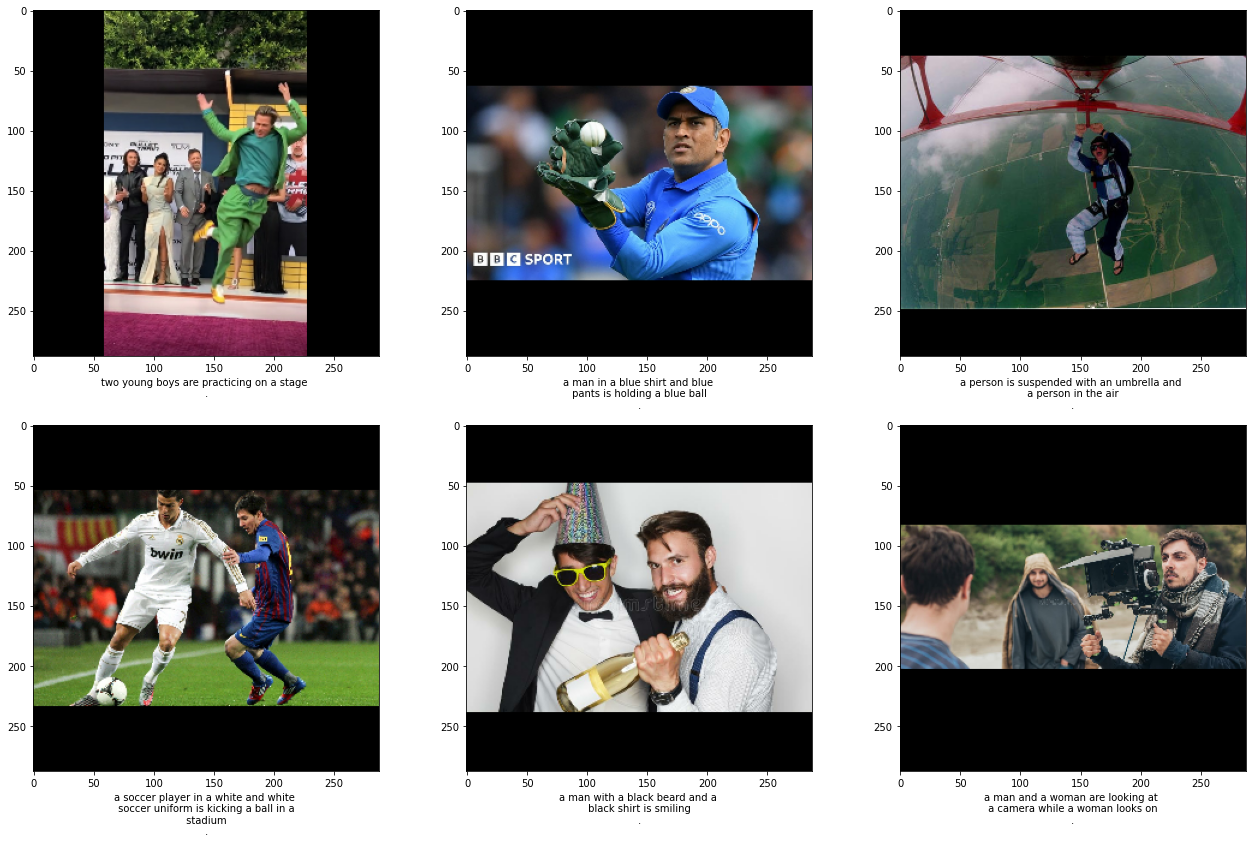

In [16]:
sample_set = 6
row =2
testdir = glob("assets/testfiles/*")
shuffle(testdir)
testdir = testdir[:sample_set]

fig,axes = plt.subplots(row,sample_set//row,figsize=(22,14))
axes = axes.flatten()

for i,j in enumerate(testdir):
    array = preprocess_image(j,image_size=(image_size[0],image_size[1]))
    decoded_text = predict_caption(imarray=array,model=caption_net,vectorizer=vectorizer,
                                   mapping=TARGET_VOCAB_MAPPING,length=DECODE_SEQUENCE_LENGTH)
    axes[i-1].imshow(tf.cast(array[0,:,:,:],tf.uint8))
    axes[i-1].set_xlabel(decoded_text)